In [10]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from utils import *
from models import *
from tqdm import tqdm

import matplotlib.pyplot as plt


dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
d = 3
m = 8
t = 200
n = 10000
lamda = 0.2
distance = 0.1
coherent = True

array = ULA(m, lamda)
array.build_sensor_positions(distance)
array.build_array_manifold()

loss_cpu = RMSPE(d, 'cpu')
loss_cuda = RMSPE(d, 'cuda')

path = 'saved_models/'

SNRs = [-10.0, -5.0, 0.0, 5.0, 10.0, 15.0, 20.0]
methods = []
mean_mse = {}

In [3]:
music = MUSIC(d, array, -torch.pi/2, torch.pi/2, 360)

methods.append("MUSIC")
mean_mse["MUSIC"] = []

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array, coherent)

    results_music = []
    for i in range(observations.shape[0]):
        theta_est, _ = music.estimate(observations[i].T, False)
        results_music.append(theta_est)
    results_music = torch.stack(results_music, dim=0)
    
    mse_music = loss_cpu(results_music, angles)
    mean_mse['MUSIC'].append(mse_music)

In [4]:
array_music = ULA(4, lamda)
array_music.build_sensor_positions(distance)
array_music.build_array_manifold()

music = MUSIC(d, array_music, -torch.pi/2, torch.pi/2, 360)

methods.append("MUSIC + spatial smoothing")
mean_mse["MUSIC + spatial smoothing"] = []

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array, coherent)

    results_music = []
    for i in range(observations.shape[0]):
        theta_est, _ = music.estimate(observations[i].T, True)
        results_music.append(theta_est)
    results_music = torch.stack(results_music, dim=0)
    
    mse_music = loss_cpu(results_music, angles)
    mean_mse['MUSIC + spatial smoothing'].append(mse_music)

In [5]:
methods.append("DA-MUSIC")
mean_mse["DA-MUSIC"] = []

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array, coherent)

    test_set = DATASET(observations, angles)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    da_music = DA_MUSIC(m, d, array, dev)
    mean_mse['DA-MUSIC'].append(test(da_music, test_loader, path+'da_music_'+str(snr)+'dB.pth', loss_cuda, dev))

In [6]:
methods.append("Proposed Modified DA-MUSIC")
mean_mse["Proposed Modified DA-MUSIC"] = []

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array, coherent)

    test_set = DATASET(observations, angles)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    da_music_v2 = DA_MUSIC_v2(m, d, array, dev)
    mean_mse['Proposed Modified DA-MUSIC'].append(test(da_music_v2, test_loader, path+'da_music_v2_'+str(snr)+'dB.pth', loss_cuda, dev))

In [7]:
methods.append("Proposed DD Model")
mean_mse["Proposed DD Model"] = []

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array, coherent)

    test_set = DATASET(observations, angles)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    rnn = RNN(m, d, dev)
    mean_mse['Proposed DD Model'].append(test(rnn, test_loader, path+'rnn_'+str(snr)+'dB.pth', loss_cuda, dev))

In [8]:
torch.save(mean_mse, 'mean_mse.pth')
mean_mse = torch.load('mean_mse.pth')

/tmp/ipykernel_12341/4234131840.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mean_mse = torch.load('mean_mse.pth')


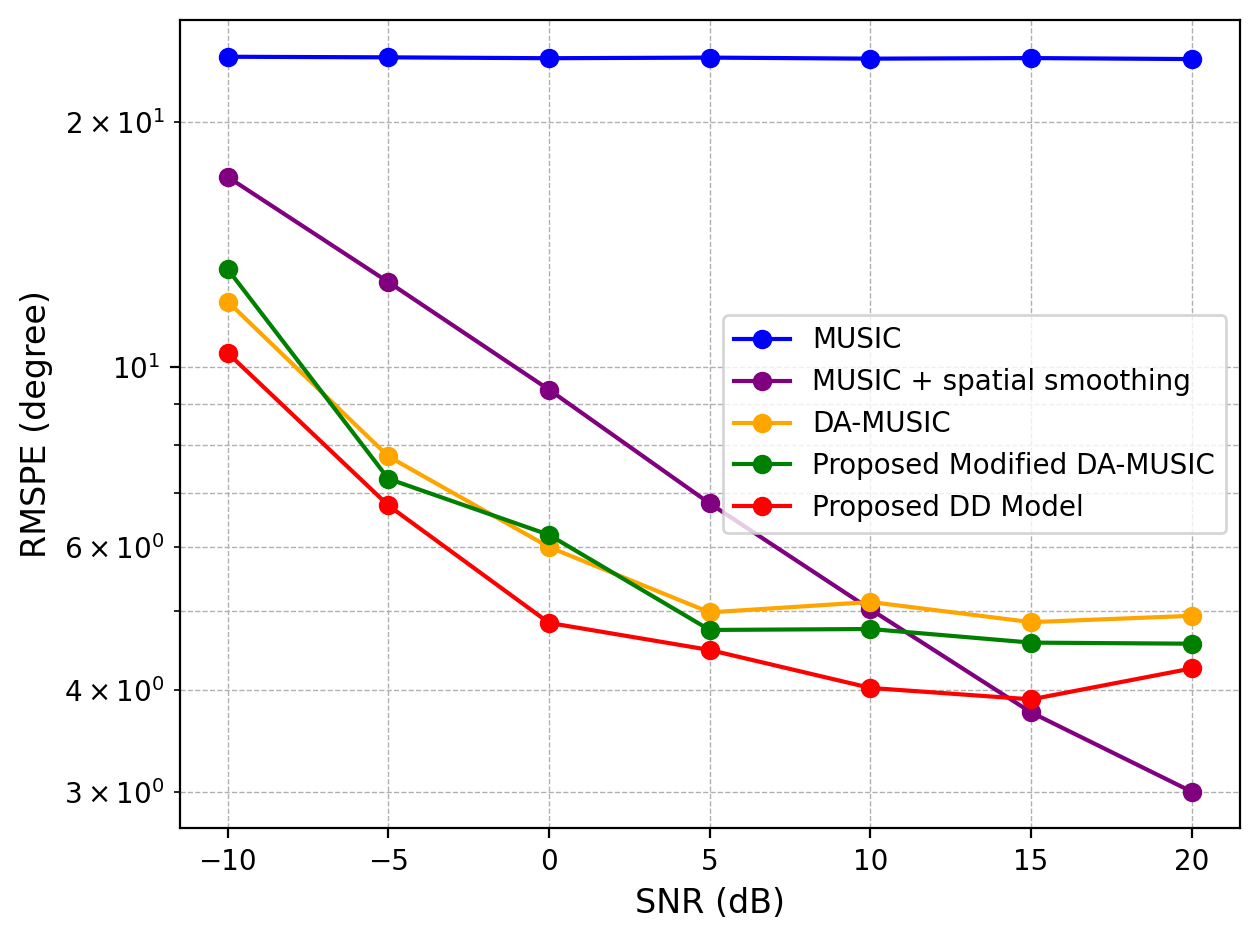

In [9]:
# plt.figure(figsize=(10, 6))
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray']
plt.rcParams['figure.dpi'] = 200
colors = ['blue', 'purple', 'orange', 'green', 'red']
for i, method in enumerate(methods):
    plt.plot(SNRs, [x/torch.pi*180 for x in mean_mse[method]], marker='o', label=method, color=colors[i])

plt.yscale("log")
# plt.title("{} scenarios".format(n), fontsize=14)
plt.xlabel("SNR (dB)", fontsize=12)
plt.ylabel("RMSPE (degree)", fontsize=12)
plt.xticks(SNRs)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
# plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()